# Extractive question answering

Extractive question answering involves posing question about document and identyfying the answers as spans of text on the document itself.

We will fine-tune a BERT model on the CoQA dataset, which consists of conversational questions posed by crowdworkers based on a diverse set of stories. Unlike traditional question-answering datasets, answers in CoQA are not always direct spans from the text. Sometimes, they are more interpretive or require reasoning, such as responding with "the garrison first" when the text only mentions "the garrison." Therefore, we need to be careful when evaluating the model, as it must handle these nuances and provide accurate answers even when they are not explicit text spans.

WE SHOULD PROBABLY GENERATE NEW ANSWERS BASED ON THE (ANSWER_START, ANSWER_END) PAIRS TO HAVE PERFECTLY PREPARED FOR THIS KIND OF TASKS DATASET.

In [1]:
from datasets import load_dataset, Dataset, DatasetDict, load_dataset

ds = load_dataset("stanfordnlp/coqa")

Let's examine the structure and organization of our dataset to understand how it is formatted.

In [2]:
id = 4
print('story:', ds['train'][4]['story'])
print('question:', ds['train'][4]['questions'])
print('answer:', ds['train'][4]['answers'])

story: CHAPTER XXIV. THE INTERRUPTED MASS 

The morning of that Wednesday of Corpus Christi, fateful to all concerned in this chronicle, dawned misty and grey, and the air was chilled by the wind that blew from the sea. The chapel bell tinkled out its summons, and the garrison trooped faithfully to Mass. 

Presently came Monna Valentina, followed by her ladies, her pages, and lastly, Peppe, wearing under his thin mask of piety an air of eager anxiety and unrest. Valentina was very pale, and round her eyes there were dark circles that told of sleeplessness, and as she bowed her head in prayer, her ladies observed that tears were falling on the illuminated Mass-book over which she bent. And now came Fra Domenico from the sacristy in the white chasuble that the Church ordains for the Corpus Christi feast, followed by a page in a clerkly gown of black, and the Mass commenced. 

There were absent only from the gathering Gonzaga and Fortemani, besides a sentry and the three prisoners. France

Current Dataset Structure<br>
In the current CoQA dataset structure, each entry consists of a story followed by a list of questions and corresponding answers. For example, you might see something like this:

Story:<br>
"The morning of that Wednesday of Corpus Christi, fateful to all concerned in this chronicle, dawned misty and grey..."

Questions: 
- Who arrived at the church?
- Who was followed by a clerk dressed in black?
- Who was crying?
- Who noticed it?

Answers:<br>
- The garrison first
- Fra. Domenico
- Valentina
- Her ladies 

One issue we can observe here is with the fourth question, "Who noticed it?" This question is ambiguous on its own and only makes sense when considered in the context of the second question. Without that context, it's unclear what the question is referring to, making it difficult to provide an accurate answer. This is another issue with the dataset that could affect efficient fine-tuning.
<br>
<br>
Required Modification <br>
To fine-tune the BERT model effectively, we need to convert each story, question, and answer into a single entry. This restructuring helps the model learn from individual question-answer pairs associated with the story, enabling it to handle each one independently:

In [3]:
ds.items()

dict_items([('train', Dataset({
    features: ['source', 'story', 'questions', 'answers'],
    num_rows: 7199
})), ('validation', Dataset({
    features: ['source', 'story', 'questions', 'answers'],
    num_rows: 500
}))])

In [4]:
from datasets import Dataset, DatasetDict

# Function to split the dataset into individual rows per question and answer
def split_data(dataset, split_name):
    new_rows = {key: [] for key in ['id', 'source', 'story', 'question', 'answer', 'answer_start', 'answer_end']}
    
    for row_index, row in enumerate(dataset):
        story = row['story']
        source = row['source']
        questions = row['questions']
        answers = row['answers']['input_text']
        answer_starts = row['answers']['answer_start']
        answer_ends = row['answers']['answer_end']
        
        for i, question in enumerate(questions):
            unique_id = f"{split_name}_{row_index}_{i}"
            new_rows['id'].append(unique_id)
            new_rows['source'].append(source)
            new_rows['story'].append(story)
            new_rows['question'].append(question)
            new_rows['answer'].append(answers[i])
            new_rows['answer_start'].append(answer_starts[i])
            new_rows['answer_end'].append(answer_ends[i])
    
    return Dataset.from_dict(new_rows)

# Apply the function to each split in the DatasetDict
raw_datasets = DatasetDict({
    split: split_data(dataset, split) for split, dataset in ds.items()
})
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'story', 'question', 'answer', 'answer_start', 'answer_end'],
        num_rows: 108647
    })
    validation: Dataset({
        features: ['id', 'source', 'story', 'question', 'answer', 'answer_start', 'answer_end'],
        num_rows: 7983
    })
})


In [5]:
idx = 1555
ex_answer_start = raw_datasets["train"][idx]['answer_start']
ex_answer_end = raw_datasets["train"][idx]['answer_end']

print("Context: ", raw_datasets["train"][idx]["story"])
print("Question: ", raw_datasets["train"][idx]["question"])
print("Answer: ", raw_datasets["train"][idx]["answer"])
print("Answer generated by answer_start, answer_end pair: ", raw_datasets["train"][idx]["story"][ex_answer_start:ex_answer_end])

Context:  When we talk about red packets, the most important question is "What are you going to do with it?" One thing you could do is to put your money in the bank. Maybe you don't know, some students in Hubei began to use the Xiaogui Dangjia bank card this year. This is a card for children. It is from China Minsheng Bank in Wuhan. Wang Ming is a 14-year-old junior student in Wuhan. He said "All my pocket money has a place to go now. I can pay my own school fees ." Zhu Yu, a manager of Minsheng Bank, said that they knew lots of students who didn't know how to use their money. So they wanted them to know how to use it carefully. Parents worry that children don't know how to take care of the money by themselves. Shen qiangqiang's mother like the card very much. Shen was asking his mother for a computer for a long time, but his mother didn't buy it for him. She said, "We want him to use his card to save money for the computer. If we buy everything he asks for, he will think money comes t

Now that the dataset is structured with each example containing one story, one question, and one answer, we can move on to the tokenization part. 

# Tokenization
We are passing context and question together and it will properly insert tokens to form a sentence like this: [CLS] question [SEP] context [SEP] <br>
As mentioned previously, we’ll be fine-tuning a BERT model.

In [6]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Let's double check on one example:

In [7]:
context = raw_datasets['train'][7]["story"]
question = raw_datasets['train'][7]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] what is the official name of the Vat? [SEP] The Vatican Apostolic Library ( ), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75, 000 codices from throughout history, as well as 1. 1 million printed books, which include some 8, 500 incunabula. The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. In March 2014, the Vatican Library began an initial four - year project of digitising its collection of manuscripts, to be made available online. The Vatican Secret Archives were sepa

The labels will then be the index of the tokens starting and ending the answer, and the model will be tasked to predicted one start and end logit per token in the input, with the theoretical labels being as follows: <br>
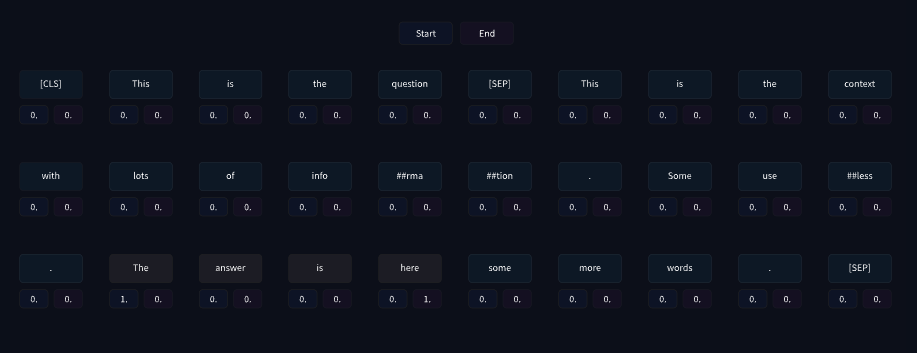

Let's keep in mind that answers in CoQA are not always direct spans from the text. Sometimes, they are more interpretive or require reasoning, so we need to consider this when evaluating the model.

Some of the examples in the dataset have very long contexts that will exceed the maximum length we set (which is 384 in this case). We will deal with long contexts by creating several training features from one sample of our dataset, with a sliding window between them.
To see how this works using the current example, we can limit the length to 100 and use a sliding window of 50 tokens. We use:

- max_length to set the maximum length (here 100)
- truncation="only_second" to truncate the context (which is in the second position) when the question with its context is too long
- stride to set the number of overlapping tokens between two successive chunks (here 50)
- return_overflowing_tokens=True to let the tokenizer know we want the overflowing tokens.

In [14]:
#check the lenght of question + answer in terms of tensors
lenght_tokens = []
for i in range(len(raw_datasets['train'])):
    context = raw_datasets['train'][i]["story"]
    question = raw_datasets['train'][i]["question"]
    inputs = tokenizer(question, context)
    inputs_id = inputs['input_ids']
    lenght = len(inputs_id)
    lenght_tokens.append(lenght)


sorted_lengths = sorted(lenght_tokens)


Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors


In [15]:
sorted_lengths[-10:]

[1348, 1348, 1349, 1349, 1350, 1350, 1351, 1352, 1353, 1356]

The longest vectors with story + question encoded as tokens exceed 1300. 

In [8]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] what is the official name of the Vat? [SEP] The Vatican Apostolic Library ( ), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75, 000 codices from throughout history, as well as 1. 1 million printed books [SEP]
[CLS] what is the official name of the Vat? [SEP]5, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75, 000 codices from throughout history, as well as 1. 1 million printed books, which include some 8, 500 incunabula. The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone [SEP]
[CLS] what is the official name of the Vat? [SEP] from throughout

As we can see, our example has been split into seven inputs, each containing the question and some part of the context. Note that the answer to the question (“The Vatican Apostolic Library”) only appears in the first input. By dealing with long contexts in this way, we will create some training examples where the answer is not included in the context. For those examples, the labels will be start_position = end_position = 0 (so we predict the [CLS] token). We will also set these labels in the unfortunate case where the answer has been truncated, meaning we only have the start or end of it. For the examples where the answer is fully in the context, the labels will be the index of the token where the answer starts and the index of the token where the answer ends.



To map start_position and end_position to token indicies, we will use the offset mappings. We can have our tokenizer return these by passing along return_offsets_mapping=True:

In [18]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping'])

In [19]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [9]:
print(f"The 1 example gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 1 example gave 7 features.
Here is where each comes from: [0, 0, 0, 0, 0, 0, 0].


We tokenized only one example, we get list of 0 - index which tells us to which example feature belongs.

Let's tokenize more examples

In [10]:
inputs = tokenizer(
    raw_datasets['train'][2:6]["question"],
    raw_datasets['train'][2:6]["story"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 24 features.
Here is where each comes from: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3].


As we can see each example gave six features.
This information will be useful to map each feature we get to its corresponding label:
- (0, 0) if the answer is not in the corresponding span of the context
- (start_position, end_position) if the answer is in the corresponding span of the context, with start_position being the index of the token (in the input IDs) at the start of the answer and end_position being the index of the token (in the input IDs) where the answer ends

To determine which of these is the case and, if relevant, the positions of the tokens, we first find the indices that start and end the context in the input IDs. We could use the token type IDs to do this, but since those do not necessarily exist for all models (DistilBERT does not require them, for instance), we’ll instead use the sequence_ids() method of the BatchEncoding our tokenizer returns.

Once we have those token indices, we look at the corresponding offsets, which are tuples of two integers representing the span of characters inside the original context. We can thus detect if the chunk of the context in this feature starts after the answer or ends before the answer begins (in which case the label is (0, 0)). If that’s not the case, we loop to find the first and last token of the answer:

In [22]:
answers = raw_datasets["train"][2:6]["answer"]
answer_start = raw_datasets["train"][2:6]["answer_start"]
answer_end = raw_datasets["train"][2:6]["answer_end"]
start_positions = []
end_positions = []
start_con = []
end_con = []

for i, offset in enumerate(inputs["offset_mapping"]):  # "i" determines feature index
    sample_idx = inputs["overflow_to_sample_mapping"][i] #index of example (couple of features can have the same index because they can come from the same example)
    answer = answers[sample_idx] #each example have one answer, this answer is assigned to each feature which came from given example.
    start_char = answer_start[sample_idx] #get position of first character where answer begins
    end_char = answer_end[sample_idx] #get position of last character where answer end
    sequence_ids = inputs.sequence_ids(i) #None if [CEP] or [SEP], 0 if question token, 1 if story token

    # Find the start and end of the context 
    idx = 0
    while sequence_ids[idx] != 1: #if sequence_ids[idx] is not token in context we add 1 and thats how we got index of token which starts context
        idx += 1
    context_start = idx 
    start_con.append(context_start)
    while sequence_ids[idx] == 1: #here we get index of last token in context, position of last token 
        idx += 1
    context_end = idx - 1 
    end_con.append(context_end)

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char: #offset[context_start] - outputs (x,y), where x is position in context where given token starts (in tems of characters), y is where token end.
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

print(start_positions)
print(end_positions)

[0, 63, 20, 0, 0, 0, 0, 59, 14, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 59, 19]
[0, 72, 29, 0, 0, 0, 0, 74, 29, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 0, 0, 70, 30]


In [23]:
sorted(raw_datasets['train']['answer_start'])[-5:] #answer starts even after 6k characters.

[4346, 4390, 4714, 4975, 6065]

Let’s take a look at a few results to verify that our approach is correct. For the second feature we find (63, 72) as labels, so let’s compare the theoretical answer with the decoded span of tokens from 63 to 72 (inclusive):

In [24]:
idx = 1 #idx of feature
sample_idx = inputs["overflow_to_sample_mapping"][idx] #idx of example for given feature
theoretical_answer  = answers[sample_idx]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs['input_ids'][idx][start:end+1])

print('Theoretical_answer:', theoretical_answer, 'Labeled_answer:', labeled_answer )

Theoretical_answer: history, and law Labeled_answer: Vatican Library is a research library for history, law


So, once again, it's important to remember that the (answer_start, answer_end) pair doesn't necessarily specify the exact answer assigned to the example.

Now that we have seen step by step how to preprocess our training data, we can group it in a function we will apply on the whole training dataset. We’ll pad every feature to the maximum length we set, as most of the contexts will be long (and the corresponding samples will be split into several features), so there is no real benefit to applying dynamic padding here:

In [27]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["story"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answer"]
    answer_start = examples["answer_start"]
    answer_end = examples["answer_end"]
    start_positions = []
    end_positions = []


    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i] #index of example (couple of features can have the same index because they can come from the same example)
        answer = answers[sample_idx] #each example have one answer, this answer is assigned to each feature which came from given example.
        start_char = answer_start[sample_idx] #get position of first character where answer begins
        end_char = answer_end[sample_idx] #get position of last character where answer end
        sequence_ids = inputs.sequence_ids(i) #None if [CEP] or [SEP], 0 if question token, 1 if story token
        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [28]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/108647 [00:00<?, ? examples/s]

(108647, 151990)

In [29]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 151990
})

### train_dataset:
 - input_ids - ids of tokens 
 - tokens_type_ids - 0- question, 1 - context
 - attention_mask - 1 -if  context and question tokens, 0 - padding.
 - start_positions - position in the context of first token of the answer

#(108647, 151990)

In [50]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 151990
})

In [51]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping'])

## Processing the validation data

In [32]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["story"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [33]:
raw_datasets["validation"]

Dataset({
    features: ['id', 'source', 'story', 'question', 'answer', 'answer_start', 'answer_end'],
    num_rows: 7983
})

In [34]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/7983 [00:00<?, ? examples/s]

(7983, 10951)

### validation_dataset
- input_ids - ids of tokens
- token_type_ids - 0 question, 1 context
- attention_mask -  1 - if  context and question tokens, 0 - padding.
- offset mapping - None for questions, for context [0, 5],[6, 10],[11, 13],[14, 17] etc. For example: the token span [5,8] indicates that the token begins at the 5th character position in the context and ends at the 8th character position.

In [35]:
from collections import Counter
validation_dataset['example_id']

# Get counts
counts = Counter(validation_dataset['example_id'])

# Print the counts
print(counts)

Counter({'validation_364_0': 4, 'validation_364_1': 4, 'validation_364_2': 4, 'validation_364_3': 4, 'validation_364_4': 4, 'validation_364_5': 4, 'validation_364_6': 4, 'validation_364_7': 4, 'validation_364_8': 4, 'validation_364_9': 4, 'validation_364_10': 4, 'validation_364_11': 4, 'validation_364_12': 4, 'validation_364_13': 4, 'validation_364_14': 4, 'validation_364_15': 4, 'validation_364_16': 4, 'validation_364_17': 4, 'validation_364_18': 4, 'validation_364_19': 4, 'validation_364_20': 4, 'validation_460_0': 4, 'validation_460_1': 4, 'validation_460_2': 4, 'validation_460_3': 4, 'validation_460_4': 4, 'validation_460_5': 4, 'validation_460_6': 4, 'validation_460_7': 4, 'validation_460_8': 4, 'validation_460_9': 4, 'validation_460_10': 4, 'validation_460_11': 4, 'validation_460_12': 4, 'validation_125_0': 3, 'validation_125_1': 3, 'validation_125_2': 3, 'validation_125_3': 3, 'validation_125_4': 3, 'validation_125_5': 3, 'validation_125_6': 3, 'validation_125_7': 3, 'validation

## Fine-tuning the model with the Trainer API

##### Post-processing

The model will output logits for the start and end positions of the answer in the input IDs. The post-processing step:
- We masked the start and end logits corresponding to tokens outside of the context.
- We take 20 highest logits within start_token and end_token predicted logits, and we assign scores to chosen pairs (start_token,end_token) by taking the sum of the start and end logits and we looked for the pair with the maximum score.

To demonstrate all of this, we will need some kind of predictions. Since we have not trained our model yet, we are going to use the default model for the QA pipeline to generate some predictions on a small part of the validation set. We can use the same processing function as before; because it relies on the global constant tokenizer, we just have to change that object to the tokenizer of the model we want to use temporarily:


In [36]:
small_eval_set = raw_datasets["validation"].select(range(100))
trained_checkpoint = "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Now that the preprocessing is done, we change the tokenizer back to the one we originally picked:

In [37]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [38]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

In [39]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Now, we need to find the predicted answer for each example in our small_eval_set. One example may have been split into several features in eval_set, so the first step is to map each example in small_eval_set to the corresponding features in eval_set:

In [40]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

In [41]:
example_to_features

defaultdict(list,
            {'validation_0_0': [0],
             'validation_0_1': [1],
             'validation_0_2': [2],
             'validation_0_3': [3],
             'validation_0_4': [4],
             'validation_0_5': [5],
             'validation_0_6': [6],
             'validation_0_7': [7],
             'validation_0_8': [8],
             'validation_0_9': [9],
             'validation_0_10': [10],
             'validation_0_11': [11],
             'validation_1_0': [12],
             'validation_1_1': [13],
             'validation_1_2': [14],
             'validation_1_3': [15],
             'validation_1_4': [16],
             'validation_1_5': [17],
             'validation_1_6': [18],
             'validation_1_7': [19],
             'validation_1_8': [20],
             'validation_1_9': [21],
             'validation_1_10': [22],
             'validation_2_0': [23, 24],
             'validation_2_1': [25, 26],
             'validation_2_2': [27, 28],
             'v

With this in hand, we can really get to work by looping through all the examples and, for each example, through all the associated features. As we said before, we’ll look at the logit scores for the n_best start logits and end logits, excluding positions that give:

- An answer that wouldn’t be inside the context
- An answer with negative length
- n answer that is too long (we limit the possibilities at max_answer_length=30)

Once we have all the scored possible answers for one example, we just pick the one with the best logit score:

In [42]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["story"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

The final format of the predicted answers is the one that will be expected by the metric we will use.

In [30]:
import evaluate

metric = evaluate.load("squad")

In [43]:
theoretical_answers = [
    {"id": ex["id"], 'answers': {'text': [ex['answer']], 'answer_start': [ex['answer_start']]}} for ex in small_eval_set
]

In [44]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 23.0, 'f1': 28.76419413919414}

Now let’s put everything we just did in a compute_metrics() function that we will use in the Trainer. Normally, that compute_metrics() function only receives a tuple eval_preds with logits and labels. Here we will need a bit more, as we have to look in the dataset of features for the offset and in the dataset of examples for the original contexts, so we won’t be able to use this function to get regular evaluation results during training. We will only use it at the end of training to check the results.

The compute_metrics() function groups the same steps as before; we just add a small check in case we don’t come up with any valid answers (in which case we predict an empty string).

In [45]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["story"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [
    {"id": ex["id"], 'answers': {'text': [ex['answer']], 'answer_start': [ex['answer_start']]}} for ex in examples]
    return predicted_answers, theoretical_answers, metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [46]:
predicted_answers, theoretical_answer, metrics = compute_metrics(start_logits, end_logits, eval_set, small_eval_set)
metrics

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 23.0, 'f1': 28.76419413919414}

In [94]:
predicted_answers, theoretical_answer

([{'id': 'validation_0_0', 'prediction_text': 'white kitten named Cotton'},
  {'id': 'validation_0_1',
   'prediction_text': 'Cotton lived high up in a nice warm place above the barn'},
  {'id': 'validation_0_2',
   'prediction_text': "But Cotton wasn't alone in her little home above the barn, oh no"},
  {'id': 'validation_0_3',
   'prediction_text': 'She shared her hay bed with her mommy and 5 other sisters'},
  {'id': 'validation_0_4', 'prediction_text': 'orange'},
  {'id': 'validation_0_5',
   'prediction_text': 'Being different made Cotton quite sad'},
  {'id': 'validation_0_6',
   'prediction_text': 'she used it to paint herself like them'},
  {'id': 'validation_0_7', 'prediction_text': "the old farmer's orange paint"},
  {'id': 'validation_0_8',
   'prediction_text': 'When her mommy and sisters found her they started laughing.'},
  {'id': 'validation_0_9',
   'prediction_text': "Her sisters licked her face until Cotton's fur was all all dry."},
  {'id': 'validation_0_10', 'predic

Values are the same as before, so we are good.

### Fine-tuning the model

We are now ready to train our model. Let’s create it first, using the AutoModelForQuestionAnswering class like before:

In [47]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Logging in to Hugging Face in order to have possibility to push model to Hub.

In [48]:
from huggingface_hub import notebook_login

notebook_login()

In [49]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-coqa_1",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,  # Increase number of epochs to allow further fine-tuning
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
    max_grad_norm=1.0,  # Apply gradient clipping
    lr_scheduler_type="cosine_with_restarts",  # Change to cosine annealing scheduler
)

c:\Users\Kuba\proba\.venv\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pass everything to trainer.

In [117]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

  0%|          | 0/94995 [00:00<?, ?it/s]

{'loss': 1.8198, 'grad_norm': 20.25730323791504, 'learning_rate': 1.99986492615712e-05, 'epoch': 0.03}
{'loss': 1.7621, 'grad_norm': 31.21404266357422, 'learning_rate': 1.9994564753730426e-05, 'epoch': 0.05}
{'loss': 1.6637, 'grad_norm': 12.020866394042969, 'learning_rate': 1.9987747544042395e-05, 'epoch': 0.08}
{'loss': 1.6808, 'grad_norm': 20.135072708129883, 'learning_rate': 1.9978199496460347e-05, 'epoch': 0.11}
{'loss': 1.6189, 'grad_norm': 43.169715881347656, 'learning_rate': 1.9965923221599958e-05, 'epoch': 0.13}
{'loss': 1.6044, 'grad_norm': 20.289552688598633, 'learning_rate': 1.995092207602549e-05, 'epoch': 0.16}
{'loss': 1.6196, 'grad_norm': 39.832489013671875, 'learning_rate': 1.993320016133209e-05, 'epoch': 0.18}
{'loss': 1.5851, 'grad_norm': 26.72047996520996, 'learning_rate': 1.9912805905601962e-05, 'epoch': 0.21}
{'loss': 1.5883, 'grad_norm': 43.81199264526367, 'learning_rate': 1.988971213273285e-05, 'epoch': 0.24}
{'loss': 1.5515, 'grad_norm': 26.580562591552734, 'lear

KeyboardInterrupt: 

Training takes some time, over 3 hours on my GPU. We can use model which I have trained by loading it like that:

In [66]:
from transformers import Trainer
from accelerate import Accelerator
from transformers import AutoTokenizer, AutoModelForQuestionAnswering


tokenizer = AutoTokenizer.from_pretrained("kubabp9/bert-finetuned-coqa")
model = AutoModelForQuestionAnswering.from_pretrained("kubabp9/bert-finetuned-coqa")
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

from accelerate import Accelerator

# Initialize the accelerator
accelerator = Accelerator()

In [67]:
eval_set

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 151
})

In [68]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
predicted_answers_1, theoretical_answers_1, metrics = compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets['validation'])

  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/7983 [00:00<?, ?it/s]

In [69]:
metrics #{'exact_match': 7.60365777276713, 'f1': 29.11301591743508} coqa1, {'exact_match': 7.578604534636102, 'f1': 29.25867417200516} coqa

{'exact_match': 7.578604534636102, 'f1': 29.25867417200516}

In [70]:
predicted_answers_1

[{'id': 'validation_0_0', 'prediction_text': 'white kitten named Cotton'},
 {'id': 'validation_0_1',
  'prediction_text': 'Once upon a time, in a barn near a farm house'},
 {'id': 'validation_0_2',
  'prediction_text': "Cotton wasn't alone in her little home above the barn, oh no"},
 {'id': 'validation_0_3',
  'prediction_text': 'She shared her hay bed with her mommy'},
 {'id': 'validation_0_4',
  'prediction_text': 'The rest of her sisters were all orange'},
 {'id': 'validation_0_5',
  'prediction_text': 'Being different made Cotton quite sad'},
 {'id': 'validation_0_6',
  'prediction_text': 'she used it to paint herself like them'},
 {'id': 'validation_0_7', 'prediction_text': "the old farmer's orange paint"},
 {'id': 'validation_0_8',
  'prediction_text': 'When her mommy and sisters found her they started laughing'},
 {'id': 'validation_0_9',
  'prediction_text': "Cotton's mommy picked her up and dropped her into a big bucket of water"},
 {'id': 'validation_0_10',
  'prediction_text

We got pretty bad results, let's try to understand why? :(

Let's focus firsty on 'exact_match' part of metric, 'exact_match' gives 1 only if the predicted are theoretical answer are exactly the same. 

In [71]:
idx = 1
print('question:', raw_datasets["validation"]['question'][idx])
print('theoretical answer:', raw_datasets["validation"]['answer'][idx])
print('predicted answer', predicted_answers_1[idx])

question: Where did she live?
theoretical answer: in a barn
predicted answer {'id': 'validation_0_1', 'prediction_text': 'Once upon a time, in a barn near a farm house'}


In [72]:
test = validation_dataset.filter(lambda example: example['example_id'] == predicted_answers_1[idx]['id'])

Filter:   0%|          | 0/10951 [00:00<?, ? examples/s]

In [73]:
predictions, _, _ = trainer.predict(test)
start_logits, end_logits = predictions
predicted_answers_test, theoretical_answers_test, metrics = compute_metrics(start_logits, end_logits, test, raw_datasets["validation"].filter(lambda example: example['id'] == predicted_answers_1[idx]['id']))
metrics

  0%|          | 0/1 [00:00<?, ?it/s]

Filter:   0%|          | 0/7983 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'exact_match': 0.0, 'f1': 40.0}

In [74]:
# trainer.push_to_hub(commit_message="Training complete")


In our example, the predicted answer is "in a barn near a farmhouse," while the expected answer is "in a barn." Although these answers are generally the same in meaning, the 'exact_match' score is 0. This demonstrates that the 'exact match' metric may not always provide an accurate evaluation of the model's performance, and therefore, it shouldn't be solely relied upon as a true indicator of performance.

Let's take a look on the 'f1' part of the metric. It is calculated as follows:
1. Tokenization
- Theoretical Tokens: ["in", "a", "barn"]
- Predicted Tokens: ["in", "a", "barn", "near", "a", "farm", "house"]
2. Common Tokens:
- he common tokens between the theoretical and predicted answers are ["in", "a", "barn"].
- Number of Common Tokens: 3
3. Precision, Recall, F1:
- Precision = Number of Predicted Tokens / Number of Common Tokens = 7 / 3 ≈0.4286
- Recall = Number of Common Tokens / Number of Theoretical Tokens = 1 / 1
- F1 = 2 x (Precision x Recall) / (Precision + Recall) ≈0.5714 

So even if predicted answer is correct we get small values of 'f1' and 'exact score'. 

### Different approach to the calculation of model performance

This approach calculates a performance metric based on whether all the words in the predicted answer are present in the expected answer.

In [76]:
def performance_string_inv(list1, list2):
    # Initialize counter
    count = 0
    count_match = 0

    # Ensure both lists are of the same length
    #assert len(list1) == len(list2), "The lists must be of the same length."

    # Iterate through both lists element-wise
    for theory, predicted in zip(list1, list2):
        count +=1
        # Split each string into a set of lowercase words to avoid case-sensitivity issues
        words1 = set(theory['answers']['text'][0].lower().split())
        words2 = set(predicted['prediction_text'].lower().split())

        # Check for any overlap
        if words1.issubset(words2):
            count_match += 1

    return count_match/count

# Call the function
result = performance_string_inv(theoretical_answers_1, predicted_answers_1)

# Print the result
print("Performance of model:", result)

Performance of model: 0.39283477389452587


Performance of the model in such defined metric is around 40%.

Let's take a look on the remaineded 60% of cases.

In [77]:
def print_wrong_predictions(list1, list2):
    # Initialize counter
    wrong_predictions = []
    # Iterate through both lists element-wise
    for theory, predicted in zip(list1, list2):
        # Split each string into a set of lowercase words to avoid case-sensitivity issues
        words1 = set(theory['answers']['text'][0].lower().split())
        words2 = set(predicted['prediction_text'].lower().split())

        # Check for any overlap
        if words1.issubset(words2) or words2.issubset(words1):
            continue
        else:
            wrong_predictions.append({
                'id': theory['id'],
                'theoretical_answer': theory['answers']['text'][0],
                'predicted_answer': predicted['prediction_text']
            })
    return wrong_predictions

def print_good_predictions(list1, list2):
    # Initialize counter
    good_predictions = []
    # Iterate through both lists element-wise
    for theory, predicted in zip(list1, list2):
        # Split each string into a set of lowercase words to avoid case-sensitivity issues
        words1 = set(theory['answers']['text'][0].lower().split())
        words2 = set(predicted['prediction_text'].lower().split())

        # Check for any overlap
        if words1.issubset(words2) or words2.issubset(words1):
            good_predictions.append({
                'id': theory['id'],
                'theoretical_answer': theory['answers']['text'][0],
                'predicted_answer': predicted['prediction_text']
            })
        else:
            continue

    return good_predictions

In [79]:
print_wrong_predictions(theoretical_answers_1, predicted_answers_1)[50:]

[{'id': 'validation_4_8',
  'theoretical_answer': 'No',
  'predicted_answer': "She saw that Quinton's mother's car wasn't in their driveway"},
 {'id': 'validation_4_9',
  'theoretical_answer': 'No',
  'predicted_answer': "Kendra didn't want to miss the bus to school"},
 {'id': 'validation_4_11',
  'theoretical_answer': 'yes',
  'predicted_answer': 'She told him what happened and he said that he was sure that everything would be okay'},
 {'id': 'validation_4_14',
  'theoretical_answer': 'No',
  'predicted_answer': 'The teacher smiled and told her not to worry'},
 {'id': 'validation_4_17',
  'theoretical_answer': 'yes',
  'predicted_answer': 'like normal tomorrow.'},
 {'id': 'validation_5_0',
  'theoretical_answer': 'five',
  'predicted_answer': 'The East Shore is home to the F.D.R. Boardwalk, the fourth-longest in the world. The'},
 {'id': 'validation_5_3',
  'theoretical_answer': 'Yes',
  'predicted_answer': 'Staten Island is the southernmost part of both the city and state of New York

What can we observe just for looking at printed examples? There is a lot of theoretical answers which are 'yes' or 'no' - so model is not good at answering the question by saying 'yes' or 'no', it rather use text directly from the story. 

We could also get rid off dots, which also caused that theoretical answer: {'asta.'} predicted answer: {'asta'} are treated by all the metric which we discussed as different answers. 

In [140]:
#getting rid of 'yes', 'no' answers in theoretical answers.
#theoretical_answers_1.filter(lambda example: example['example_id'] == predicted_answers_1[idx]['id'])

In [80]:
def filter_answers_yes_no(answers_list):
    # Define the set of words to exclude
    exclude_set = {'yes', 'no'}

    # Use list comprehension to filter out entries with 'yes' or 'no'
    filtered_list = [
        entry for entry in answers_list
        if entry['answers']['text'][0].lower() not in exclude_set
    ]

    return filtered_list

In [81]:
theoretical_answers_yes_no_exl = filter_answers_yes_no(theoretical_answers_1)

In [82]:
num_excluded = len(theoretical_answers_1) - len(theoretical_answers_yes_no_exl)
# Print the result
print(f"There was {num_excluded} 'yes' or 'no' answer in theoretical answers.")

There was 1472 'yes' or 'no' answer in theoretical answers.


In [83]:
def get_excluded_ids(original_list, filtered_list):
    # Extract IDs from both lists
    original_ids = set(entry['id'] for entry in original_list)
    filtered_ids = set(entry['id'] for entry in filtered_list)

    # Find IDs present in the original list but not in the filtered list
    excluded_ids = original_ids - filtered_ids

    return excluded_ids

excluded_ids = get_excluded_ids(theoretical_answers_1, theoretical_answers_yes_no_exl)

In [84]:
def filter_predicted_answers(predicted_answers, excluded_ids):
    # Filter out predicted answers where the ID is in the excluded_ids set
    filtered_predicted_answers = [
        entry for entry in predicted_answers
        if entry['id'] not in excluded_ids
    ]

    return filtered_predicted_answers

predicted_answers_yes_no_exl = filter_predicted_answers(predicted_answers_1, excluded_ids)

In [85]:
performance_string_inv(theoretical_answers_yes_no_exl, predicted_answers_yes_no_exl)

0.4761173398863462

In [86]:
print_wrong_predictions(theoretical_answers_yes_no_exl, predicted_answers_yes_no_exl)

[{'id': 'validation_0_3',
  'theoretical_answer': 'with her mommy and 5 sisters',
  'predicted_answer': 'She shared her hay bed with her mommy'},
 {'id': 'validation_0_4',
  'theoretical_answer': 'orange and white',
  'predicted_answer': 'The rest of her sisters were all orange'},
 {'id': 'validation_0_6',
  'theoretical_answer': 'she painted herself',
  'predicted_answer': 'she used it to paint herself like them'},
 {'id': 'validation_0_7',
  'theoretical_answer': 'the farmer',
  'predicted_answer': "the old farmer's orange paint"},
 {'id': 'validation_1_0',
  'theoretical_answer': 'Asta.',
  'predicted_answer': 'Asta'},
 {'id': 'validation_1_1',
  'theoretical_answer': 'a bottle',
  'predicted_answer': '"It looks like a bird\'s belly," said Asta. But when they swam closer, it was not a bird\'s belly'},
 {'id': 'validation_1_2',
  'theoretical_answer': 'Asta.',
  'predicted_answer': "Asta's friend Sharkie"},
 {'id': 'validation_1_7',
  'theoretical_answer': "Asta's papa",
  'predicted

In [87]:
def filter_special_characters(answers_list_theory, answers_list_pred):
    # Define the set of characters to exclude
    exclude_set = {'.', ',', '!', '(', ')', '"'}

    def remove_special_chars(text):
        # Remove characters found in exclude_set from the text
        return ''.join(char for char in text if char not in exclude_set)

    # Process answers_list_theory
    filtered_theory_list = []
    for entry in answers_list_theory:
        entry_text = entry['answers']['text'][0]
        cleaned_text = remove_special_chars(entry_text)
        entry['answers']['text'][0] = cleaned_text
        filtered_theory_list.append(entry)

    # Process answers_list_pred
    filtered_pred_list = []
    for entry in answers_list_pred:
        entry_text = entry['prediction_text']
        #print(entry_text)
        cleaned_text = remove_special_chars(entry_text)
        entry['prediction_text'] = cleaned_text
        filtered_pred_list.append(entry)

    return filtered_theory_list, filtered_pred_list



In [88]:
theoretical_answers_special_char, predicted_answers_special_char = filter_special_characters(theoretical_answers_yes_no_exl, predicted_answers_yes_no_exl)

In [89]:
performance_string_inv(theoretical_answers_special_char, predicted_answers_special_char)

0.577484257410536

In [90]:
len(theoretical_answers_special_char)

6511

In [91]:
print_wrong_predictions(theoretical_answers_special_char, predicted_answers_special_char)

[{'id': 'validation_0_3',
  'theoretical_answer': 'with her mommy and 5 sisters',
  'predicted_answer': 'She shared her hay bed with her mommy'},
 {'id': 'validation_0_4',
  'theoretical_answer': 'orange and white',
  'predicted_answer': 'The rest of her sisters were all orange'},
 {'id': 'validation_0_6',
  'theoretical_answer': 'she painted herself',
  'predicted_answer': 'she used it to paint herself like them'},
 {'id': 'validation_0_7',
  'theoretical_answer': 'the farmer',
  'predicted_answer': "the old farmer's orange paint"},
 {'id': 'validation_1_1',
  'theoretical_answer': 'a bottle',
  'predicted_answer': "It looks like a bird's belly said Asta But when they swam closer it was not a bird's belly"},
 {'id': 'validation_1_2',
  'theoretical_answer': 'Asta',
  'predicted_answer': "Asta's friend Sharkie"},
 {'id': 'validation_1_7',
  'theoretical_answer': "Asta's papa",
  'predicted_answer': 'Asta could not read the note'},
 {'id': 'validation_1_8',
  'theoretical_answer': 'unkn

In [92]:
missmatch = raw_datasets['validation'].filter(lambda example: example['id'] == 'validation_0_6')

Filter:   0%|          | 0/7983 [00:00<?, ? examples/s]

In [93]:
missmatch['story']

['Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. Cotton lived high up in a nice warm place above the barn where all of the farmer\'s horses slept. But Cotton wasn\'t alone in her little home above the barn, oh no. She shared her hay bed with her mommy and 5 other sisters. All of her sisters were cute and fluffy, like Cotton. But she was the only white one in the bunch. The rest of her sisters were all orange with beautiful white tiger stripes like Cotton\'s mommy. Being different made Cotton quite sad. She often wished she looked like the rest of her family. So one day, when Cotton found a can of the old farmer\'s orange paint, she used it to paint herself like them. When her mommy and sisters found her they started laughing. \n\n"What are you doing, Cotton?!" \n\n"I only wanted to be more like you". \n\nCotton\'s mommy rubbed her face on Cotton\'s and said "Oh Cotton, but your fur is so pretty and special, like you. We would never want y

After applying the described changes, the model's performance increased to 60%.

However, further improvements could be made. For instance, when examining some of the incorrectly predicted answers:

ID: validation_0_7
- Question: Whose paint was it?
- Expected Answer: The farmer
- Predicted Answer: The old farmer's orange paint. <br>
Although the predicted answer is correct, it was marked as incorrect.

ID: validation_3_19
- Question: What had he been before?
- Expected Answer: A cop
- Predicted Answer: Farina, who had a long career as a police office. <br>
Again, the predicted answer is correct, but it was flagged as wrong.

ID: validation_0_6
- Question: What did she do to try to make herself the same color as her sisters?
- Expected Answer: She painted herself
- Predicted Answer: She used it to paint herself like them. <br>
The predicted answer is accurate, yet it was not recognized as such.

These examples suggest that the evaluation process might still need refinement to better recognize correct answers.



In [630]:
missmatch['question']

['What did she do to try to make herself the same color as her sisters?']